In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from tensorflow.keras.layers import *
from google.colab import output
import pickle

In [2]:
tf.keras.backend.set_floatx("float64")

In [3]:
dataset=pd.read_csv('/content/drive/My Drive/Datasets/Quora/dataset.tsv',delimiter='\t')

In [4]:
dataset.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
Questions1=dataset.iloc[:,3].values
Questions2=dataset.iloc[:,4].values
Duplicate=dataset.iloc[:,5].values

In [6]:
Questions1=[str(q).lower() for q in Questions1]
Questions2=[str(q).lower() for q in Questions2]

In [7]:
tokenizer=TweetTokenizer()

In [8]:
with open('/content/drive/My Drive/Datasets/Quora/glove.6B.100d.txt') as f:
  data=f.read()

In [9]:
data=data.split('\n')

In [10]:
Embeddings={}
for d in data :
  try :
    w=d.split()[0]
    embd=np.array(d.split()[1:],dtype="float")
    Embeddings[w]=embd
  except:
    pass
Embeddings['<OOV>']=0.2*np.random.random((100))
Embeddings['<PAD>']=0.8*np.random.random((100))

In [16]:
Questions1=[tokenizer.tokenize(q) for q in Questions1]
Questions2=[tokenizer.tokenize(q) for q in Questions2]

In [17]:
MAX_LEN=20

In [ ]:
np.array(Questions1[0:10])

In [19]:
#Padding
for i in range(len(Questions1)):
  if len(Questions1[i])>=20:
    Questions1[i]=Questions1[i][:20]
  else :
    Questions1[i]+=['<PAD>']*(20-len(Questions1[i]))

In [20]:
for i in range(len(Questions2)):
  if len(Questions2[i])>=20:
    Questions2[i]=Questions2[i][:20]
  else :
    Questions2[i]+=['<PAD>']*(20-len(Questions2[i]))

In [21]:
# Selecting only Duplicate Questions...
rem=[]
for i in range(len(Duplicate)):
  if Duplicate[i]==0:
    rem+=[i]

In [22]:
for rem in sorted(rem, reverse=True):
    del Questions1[rem]
    del Questions2[rem]

In [18]:
np.array(Questions1[0:2])

array([['astrology', ':', 'i', 'am', 'a', 'capricorn', 'sun', 'cap',
        'moon', 'and', 'cap', 'rising', '...', 'what', 'does', 'that',
        'say', 'about', 'me', '?'],
       ['how', 'can', 'i', 'be', 'a', 'good', 'geologist', '?', '<PAD>',
        '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>',
        '<PAD>', '<PAD>', '<PAD>', '<PAD>']], dtype='<U9')

In [19]:
np.array(Questions2[0:2])

array([["i'm", 'a', 'triple', 'capricorn', '(', 'sun', ',', 'moon',
        'and', 'ascendant', 'in', 'capricorn', ')', 'what', 'does',
        'this', 'say', 'about', 'me', '?'],
       ['what', 'should', 'i', 'do', 'to', 'be', 'a', 'great',
        'geologist', '?', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>',
        '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']], dtype='<U9')

In [23]:
def train_datagen(batch_size=32):

  global Questions1
  global Questions2
  Q1=np.zeros((batch_size,20,100))
  Q2=np.zeros((batch_size,20,100))
  curr=0
  while(True):
    if curr+batch_size>=len(Questions1):
      curr=0
      indices=range(len(Questions1))
      indices=np.random.permutation(indices)
      Questions1=Questions1[indices]
      Questions2=Questions2[indices]

    for i in range(curr,curr+32):
      for j in range(20):
        try :
          Q1[curr-i,j]=Embeddings[Questions1[i][j]]
        except :
          Q1[curr-i,j]=Embeddings['<OOV>']

    for i in range(curr,curr+32):
      for j in range(20):
        try :
          Q2[curr-i,j]=Embeddings[Questions2[i][j]]
        except :
          Q2[curr-i,j]=Embeddings['<OOV>']
    curr+=batch_size
    yield Q1,Q2

<br><hr><br>**Model Architecture**

In [24]:
# Layers...
lstm1=Bidirectional(LSTM(200,return_sequences=True))
conv1=Conv1D(400,5)
norm_conv1=BatchNormalization()
act_conv1=Activation("sigmoid")
lstm2=Bidirectional(LSTM(200,return_sequences=False))

dense1=Dense(300)
norm1=BatchNormalization()
act1=Activation("sigmoid")

dense2=Dense(100)
norm2=BatchNormalization()
act2=Activation("sigmoid")

dense3=Dense(80)
norm3=BatchNormalization()
act3=Activation("sigmoid")

In [25]:
def norm_set(val=True):
  norm_conv1.training=val
  norm1.training=val
  norm2.training=val
  norm3.training=val

In [26]:
def forward_pass(Q1,Q2):
  t1=lstm1(Q1)
  t1=conv1(t1)
  t1=norm_conv1(t1)
  t1=act_conv1(t1)
  t1=lstm2(t1)
  t1=dense1(t1)
  t1=norm1(t1)
  t1=act1(t1)
  t1=dense2(t1)
  t1=norm2(t1)
  t1=act2(t1)
  t1=dense3(t1)
  t1=norm3(t1)
  t1=tf.expand_dims(act3(t1),axis=-1)
 
  t2=lstm1(Q2)
  t2=conv1(t2)
  t2=norm_conv1(t2)
  t2=act_conv1(t2)
  t2=lstm2(t2)
  t2=dense1(t2)
  t2=norm1(t2)
  t2=act1(t2)
  t2=dense2(t2)
  t2=norm2(t2)
  t2=act2(t2)
  t2=dense3(t2)
  t2=norm3(t2)
  t2=tf.expand_dims(act3(t2),axis=-1)
  
  # Triplet Loss...
  V=tf.matmul(t1[:,:,0],tf.transpose(t2[:,:,0]))
  V=V/tf.matmul(tf.expand_dims(tf.norm(t1[:,:,0],axis=-1),axis=-1),tf.expand_dims(tf.norm(tf.transpose(t2[:,:,0]),axis=0),axis=0))
 

  Losses=[]
  mean_=0
  max_=0
  for i in range(V.shape[0]):
    for j in range(V.shape[1]):
      if i==j :
        continue
      mean_+=V[i,j]
      if max_<V[i,j]:
        max_=V[i,j]
    Losses+=[tf.math.maximum(0,mean_-V[i,i]+0.25)]
    Losses+=[tf.math.maximum(0,max_-V[i,i]+0.25)]
    mean_=0
    max_=0
 
  return tf.reduce_sum(Losses)/t1.shape[0]
  

<br><hr><br> **Save Model**

In [28]:
def save_model():
  weights={}
  weights['lstm1']=lstm1.get_weights()
  weights['conv1']=conv1.get_weights()
  weights['norm_conv1']=norm_conv1.get_weights()
  weights['lstm2']=lstm2.get_weights()
  weights['dense1']=dense1.get_weights()
  weights['norm1']=norm1.get_weights()
  weights['dense2']=dense2.get_weights()
  weights['norm2']=norm2.get_weights()
  weights['dense3']=dense3.get_weights()
  weights['norm3']=norm3.get_weights()

  with open('/content/drive/My Drive/Datasets/Quora/model.pkl','wb') as f:
    pickle.dump(weights,f)


In [29]:
def load_model():
  with open('/content/drive/My Drive/Datasets/Quora/model.pkl','rb') as f:
    weights=pickle.load(f)

  lstm1.set_weights(weights['lstm1'])
  try :
    conv1.set_weights(weights['conv1'])
    norm_conv1.set_weights(weights['norm_conv1'])
  except :
    pass
  lstm2.set_weights(weights['lstm2'])
  dense1.set_weights(weights['dense1'])
  norm1.set_weights(weights['norm1'])
  dense2.set_weights(weights['dense2'])
  norm2.set_weights(weights['norm2'])
  dense3.set_weights(weights['dense3'])
  norm3.set_weights(weights['norm3'])

<br><hr><br> **Building Backward Pass**

In [33]:
load_model()

In [30]:
indices=range(len(Questions1))
indices=np.random.permutation(indices)
Questions1=[Questions1[i] for i in indices]
Questions2=[Questions2[i] for i in indices]

In [31]:
epochs=10
batch_size=256
optimizer=tf.optimizers.Adam(1e-5)
data_gen=train_datagen()

Epoch/Batch : 2/208     Loss : 1.693944058543698


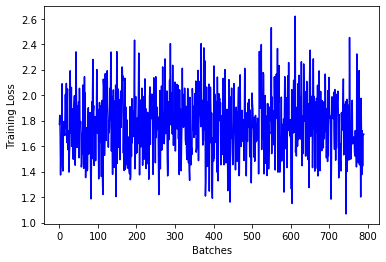

In [ ]:
#Backward Pass....
losses=[]
for epoch in range(epochs):
  for batch in range(len(Questions1)//batch_size):
    try:
      Q1,Q2=next(data_gen)
    except :
      Q1,Q2=next(data_gen)
    with tf.GradientTape() as tape:
      loss=forward_pass(Q1,Q2)
      vars=tape.watched_variables()
      grads=tape.gradient(loss,vars)
    optimizer.apply_gradients(zip(grads,vars))
    #save_model()
    output.clear(wait=True)
    losses+=[loss.numpy()]
    print("Epoch/Batch : "+str(epoch+1)+"/"+str(batch+1)+"     Loss : "+str(loss.numpy()))
    plt.plot(range(len(losses)),losses,color="blue")
    plt.xlabel("Batches")
    plt.ylabel(" Training Loss ")
    plt.show()


In [ ]:
vars

In [94]:
save_model()

In [34]:
def predict(Q1,Q2):
  norm_set(False)
  Y=np.zeros((Q1.shape[0]))

  t1=lstm1(Q1)
  t1=conv1(t1)
  t1=norm_conv1(t1)
  t1=act_conv1(t1)
  t1=lstm2(t1)
  t1=dense1(t1)
  t1=norm1(t1)
  t1=act1(t1)
  t1=dense2(t1)
  t1=norm2(t1)
  t1=act2(t1)
  t1=dense3(t1)
  t1=norm3(t1)
  t1=tf.expand_dims(act3(t1),axis=-1)
 
  t2=lstm1(Q2)
  t2=conv1(t2)
  t2=norm_conv1(t2)
  t2=act_conv1(t2)
  t2=lstm2(t2)
  t2=dense1(t2)
  t2=norm1(t2)
  t2=act1(t2)
  t2=dense2(t2)
  t2=norm2(t2)
  t2=act2(t2)
  t2=dense3(t2)
  t2=norm3(t2)
  t2=tf.expand_dims(act3(t2),axis=-1)
  
  for i in range(t1.shape[0]):
    sim=tf.matmul(tf.transpose(t1[i]),t2[i])/(tf.norm(t1[i])*tf.norm(t2[i]))
    if sim.numpy()>=0.5:
      Y[i]=1
  
  norm_set(True)
  return Y

In [35]:
# Validation Set Accuracy
def validation_accuracy(batch_size=200):
  Questions1=dataset.iloc[:,3].values
  Questions2=dataset.iloc[:,4].values
  Duplicate=dataset.iloc[:,5].values

  q1=[]
  q2=[]
  d=[]
  count=0
  for i in range(len(Duplicate)):
    if count==batch_size//2:
      break
    if Duplicate[i]==0:
      q1+=[Questions1[i]]
      q2+=[Questions2[i]]
      d+=[0]

  count=0
  for i in range(len(Duplicate)):
    if count==batch_size//2:
      break
    if Duplicate[i]==1:
      q1+=[Questions1[i]]
      q2+=[Questions2[i]]
      d+=[1]

  q1=[str(q).lower() for q in q1]
  q2=[str(q).lower() for q in q2]

  q1=[tokenizer.tokenize(q) for q in q1]
  q2=[tokenizer.tokenize(q) for q in q2]

  #Padding
  for i in range(len(q1)):
    if len(q1[i])>=20:
      q1[i]=q1[i][:20]
    else :
      q1[i]+=['<PAD>']*(20-len(q1[i]))

  for i in range(len(q2)):
    if len(q2[i])>=20:
      q2[i]=q2[i][:20]
    else :
      q2[i]+=['<PAD>']*(20-len(q2[i]))

  
  Q1=np.zeros((batch_size,20,100))
  Q2=np.zeros((batch_size,20,100))
  D=np.zeros((batch_size))


  for i in range(len(Q1)):
    D[i]=d[i]
    for j in range(20):
      try :
        Q1[i,j]=Embeddings[q1[i][j]]
      except :
        Q1[i,j]=Embeddings['<OOV>']
    for j in range(20):
      try :
        Q2[i,j]=Embeddings[q2[i][j]]
      except :
        Q2[i,j]=Embeddings['<OOV>']

  
  Y=predict(Q1,Q2)
  count=0
  for i in range(len(Y)):
    if Y[i]==D[i] :
      count+=1

  print("Val. Accuracy : "+str(count/len(Y)))

In [36]:
validation_accuracy(2000)

Val. Accuracy : 0.853


<br><hr><br> **User Generated Test Set**

In [38]:
# Note : Q1 & Q2 are Strings
def test_questions(Q1,Q2):
  Q1=Q1.lower()
  Q2=Q2.lower()
  Q1=tokenizer.tokenize(Q1)
  Q2=tokenizer.tokenize(Q2)

  q1=np.zeros((1,len(Q1),100))
  q2=np.zeros((1,len(Q2),100))

  for i in range(len(Q1)):
    try :
      q1[0,i]=Embeddings[Q1[i]]
    except :
      q1[0,i]=Embeddings["<OOV>"]
    
  for i in range(len(Q2)):
    try :
      q2[0,i]=Embeddings[Q2[i]]
    except :
      q2[0,i]=Embeddings["<OOV>"]

  Y=predict(q1,q2)
  return Y


In [45]:
Q1="how to learn machine learning?"
Q2="i want to learn machine learning but how?"
test_questions(Q1,Q2)

array([1.])

In [15]:
with open('/content/drive/My Drive/Datasets/Quora/vocab','wb') as f:
    pickle.dump(vocab,f)